# Support and Setup

In [ ]:
import snappy
M = snappy.Triangulation('4_1')
A_lit_str = 'l*m^8 - l*m^6 + l^2*m^4 - 2*l*m^4 + m^4 - l*m^2 + l'
## Do Pachner Moves Here:
#M._two_to_three(0,3)
#M._two_to_three(0,2)
#M._two_to_three(1,3)
num_tet = M.num_tetrahedra()

## Logging

You can change the logging level here.

In [ ]:
import logging

# create logger
logger = logging.getLogger(__name__)

# keep from having duplicate messages.
logger.handlers = []
logger.propagate = False

# set log level for all handlers to debug. Options are DEBUG, INFO, WARNING, ERROR, and CRITICAL.
logger.setLevel(logging.DEBUG)

# create console handler and set level to debug
# best for development or debugging
consoleHandler = logging.StreamHandler()
consoleHandler.setLevel(logging.DEBUG)



# create formatter
formatter = logging.Formatter('%(levelname)s - %(message)s')

# add formatter to ch
consoleHandler.setFormatter(formatter)

# add console hangler to logger
logger.addHandler(consoleHandler)

## Helper methods
TODO - some of these I don't use and should remove.

TODO - there are other helper methods scattered through the code, which would be good to move here.

TODO - move anything general-purpose built for quantum tori to the quantum_tori.ipynb file.

In [ ]:
import functools

def std_basis(i,dim,power=1):
    # returns (0,...,0,power,0,...,0) in ZZ^dim
    vec = [0]*dim
    vec[i] = power
    return vector(vec)

# list + list is concatenation, here's a method to add lists termwise:
# needs the library functools for reduce.
def add_termwise(*args):
    return list(reduce(lambda x,y: vector(x)+vector(y), args))

# multiply_termwise(v,w) returns (v1*w1,...,vn*wn)
def multiply_termwise(*args):
    return reduce(lambda vec1, vec2: list(map(lambda x,y: x*y, vec1,vec2)), args)
    

def get_normal_ordering_power(term,relations):
    # :ab: = q^{-n}:a: :b:, if ab = q^{2n}ba
    dim = len(vector(ZZ,term))
    scalar_power = 0
    for i in range(dim):
        if not (term[i].is_zero() or vector(term[i+1:]).is_zero()):
            leading_factor = vector([0]*dim)
            leading_factor[i] = term[i]
            trailing_terms = vector([0]*dim)
            trailing_terms[i+1:] = term[i+1:]
        
            scalar_power -= (matrix(leading_factor)*relations*matrix(trailing_terms).transpose())[0]
    return (scalar_power/2)[0]

def add_normal_ordering_scalar(list_of_terms,relations):
    new_list_of_terms = list_of_terms
    for term in new_list_of_terms:
        term[0] += get_normal_ordering_power(term,relations)
    return new_list_of_terms

def dict_monomial_to_list(monomial):
    coeff = LaurentPolynomialRing(ZZ,'qrt4')(list(monomial.values())[0])
    if not coeff.is_monomial():
        raise Exception('I can only deal with coefficients in the form q^a')
    else:
        lattice_coord = list(list(monomial.keys())[0])
        lattice_coord[0] += coeff.degree()/2 # the coeff is in terms of qrt4, qrt4^4 = q
        return lattice_coord

In [ ]:
# Functions for quantum tori - TODO combine this with the quantum_tori notebook.


def names_to_lattice_coordinate(names,gens_dict):
    """
    Gets the lattice coordinate for a monomial. Assumes the coordinates are
    Weyl normal order, e.g. ['x','y','z'] -> :xyz:
    
    Parameters:
        names (list of strings or dictionary specifying exponents) - generator names
        gens_dict (dict) - maps generator names to lattice coordinates.
    
    Returns:
        vector - the lattice coordinate of the Weyl normal order product of the given generator.
    """
    if isinstance(names,dict): # means powers are specified
        return sum([power*gens_dict[gen] for gen,power in names.items()])
    else: # its a list or set
        return sum([gens_dict[gen] for gen in names])
    
def lattice_coord_to_dict(coord,gens_dict):
    """
    Converts a lattice coordinate to a dictionary with variable names as keys and powers as values.
    Might assume that each generator's coordinate has exactly one non-zero entry.
    
    Parameters:
        coord (list or vector) - the coordinate of an element in the quantum torus
        gens_dict (dict) - the dictionary of generator lattice coordinates.
    
    Returns:
        dict - a dictionary representation of the coordinate.
    """
    dict_form = {}
    for gen_name,gen_coord in gens_dict.items():
        # divide by that entry to deal with qrt2, which is (2,0,...,0)
        # does not handle roots of other generators - they'll be set to zero by int()
        power = int(sum(ii*jj for (ii,jj) in zip(gen_coord,coord))/max(gen_coord))
        if power != 0:
            dict_form[gen_name] = power
    
    return dict_form

def lattice_coord_to_ring_element(coord,the_ring):
    """
    Turns a lattice coordinate into a ring element.
    Assumes that the coordinate and the_ring.gens() use the same order.
    This recreates the functionality of the_ring.monomial, which isn't implemented for all the rings we work with.
    
    Parameters:
        coord (List) - the lattice coordinate of a module element.
        the_ring (fgp_module) - the ambient module
    
    Returns:
        (the_ring.element_class) - the ring element corresponding to the lattice coordinate
    """
    return reduce(the_ring.product, [term[0]**term[1] for term in zip(the_ring.gens(),coord)])

def product_from_lattice_coordinates(*coords, relations=matrix.identity(3), gens_dict={'qrt2':(2,0,0),'A':(0,1,0),'a':(0,0,1)}):
    #TODO - double check that this works like I think it should.
    """
    Gets the lattice coordinate for the product X^coord1 * X^coord2 * ... * X^coordn
    This isn't simple termwise addition because lattice coordinates are in normal order, so we have a factor of q introduced.
    
    If X^coord1 * X^coord2 = q^(2n) X^coord2 * X^coord1, then 
    X^coord1 * X^coord2 = q^(-n) X^(coord1 + coord2)
    
    Parameters:
        coords (vector or list) - an arbitrary number (>=1) of lattice coordinates, in the order they're being multiplied
        relations (matrix) - the relations matrix
        gens_dict (dict) - dictionary with generator names. used to specify q.
    
    Returns:
        vector - the lattice coordinate for the product
    """
    
    get_q_power = lambda c1, c2: -(matrix(c1)*relations*matrix(c2).transpose())[0,0]
    
    return reduce(lambda c1,c2: get_q_power(c1,c2)*vector(gens_dict['qrt2'])/2+vector(c1)+vector(c2),coords)

def product_from_names(*monomials,relations=matrix.identity(3),gens_dict={'qrt2':(2,0,0),'A':(0,1,0),'a':(0,0,1)}):
    """
    Returns the product of the monomials (in normal order) in the form of a dictionary.
    
    Parameters:
        monomials (dict or list of strings) - an arbitrary number (2 or more?) of dictionarys, in the order they're being multiplied.
        relations (matrix) - gives the commutation relations
        gens_dict (dict) - maps variable names to lattice coordinates
    
    Returns:
        dict - the product in normal order.
    """
    
    coords = [names_to_lattice_coordinate(m,gens_dict) for m in monomials]
    
    return product_from_lattice_coordinates(*coords,relations=relations,gens_dict=gens_dict)

def clear_denominator(element):
    """Clears denominator by multiplying through by a monomial."""
    ambient_ring = element.parent()
    
    return ambient_ring.monomial(*[
        -min(powers) for powers in matrix(element.exponents()).transpose().rows()
    ])*element

In [36]:
product_from_lattice_coordinates(gens_dict['a002'],gens_dict['a001'],gens_dict['a001'],relations=omega_with_q,gens_dict=gens_dict)
product_from_names({'a002':1},{'a001':1},{'a001':-1}, relations=omega_with_q, gens_dict=gens_dict)
{'a':1,'b':-1} | {'b':1,'c':2}

{'a': 1, 'b': 1, 'c': 2}

In [ ]:
def merge_or_add(dict1, dict2):
    """
    A version of dict1 | dict2 which adds the values of repeated keys. Does not overwrite the original dictionaries.
    
    Example: (compare 'b' value)
    {'a':1,'b':-1} | {'b':1,'c':2}
    >> {'a': 1, 'b': 1, 'c': 2}
    merge_or_add({'a':1,'b':-1}, {'b':1,'c':2})
    >> {'a':1, 'b':0, 'c':2}
    
    Parameters:
    dict1 (dict)
    dict2 (dict)
    
    Returns:
    dict
    """
    
    union_keys = set(dict1.keys()) | set(dict2.keys())
    
    return {k : dict1.get(k,0)+dict2.get(k,0) for k in union_keys}


## Lattice Coordinates and Weights.

Also gluing data

<class 'snappy.Triangulation'>

Here's a commented version explaining some about the output of `snappy.Triangulation._to_string()`.

```

3                                       # <-- number of tetrahedron

### tetrahedron 1 ###
   1    2    1    2                     # <-- which tetrahedron face 0 1 2 3 goes too. 
 1302 3012 0132 0132                    # <-- permutations on the vertices that defines
   0    0    0    0                     #     exactly where the face goes.
  0  0  0  0  0  0  0  0  0  1  0 -1  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0 -1  0  1 -1  0  1  0  0  1  0 -1  0  1 -1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
0.0 0.0

### tetrahedron 2 ###
   2    0    2    0 
 1302 2031 0132 0132
   0    0    0    0 
  0  0  0  0  1  0 -1  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  2  0 -1 -1 -1  0  0  1  0  1 -1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
0.0 0.0

### tetrahedron 3 ###
   0    1    0    1 
 1230 2031 0132 0132
   0    0    0    0 
  0  0  0  0 -1  0  0  1  0  0  0  0  0 -1  1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  1 -1  0 -1  0  0  1 -1  0  0  1  1 -2  1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
0.0 0.0
```

In [ ]:
# Define q and some of its roots.
q = var('q')
qrt2 = var('qrt2')
qrt4 = var('qrt4')
q = qrt4^4
q = qrt2^2
qrt2 = qrt4^2


# todo - is this coeffs vector still useful?
R.<qrt4> =LaurentPolynomialRing(ZZ)
coeffs = matrix(R,[qrt2^2])


### Lattice Coordinates for Short and Long Edges

In [ ]:
# First q. The first lattice is in terms of qrt2 = q^(1/2)
gens_dict = {'qrt2': vector([1] + [0]*(num_tet*18) + [0]*(num_tet*12))}

# Generators for the skein algebra of the tetrahedra. Threads (from gluing) come later.
for t in range(M.num_tetrahedra()):
                  # qrt2 + earlier tets
    leading_zeros = 1 + 18*t
                   # later tets       + threads
    trailing_zeros = 18*(num_tet-1-t) + num_tet*12
    # short edges
    gens_dict.update(
        {                        # q + before             + short                     +  long + after & threads
            "a{0}01".format(t) : vector([0]*leading_zeros + [1,0,0,0,0,0,0,0,0,0,0,0] + [0]*(6+trailing_zeros)),
            "a{0}02".format(t) : vector([0]*leading_zeros + [0,1,0,0,0,0,0,0,0,0,0,0] + [0]*(6+trailing_zeros)),
            "a{0}03".format(t) : vector([0]*leading_zeros + [0,0,1,0,0,0,0,0,0,0,0,0] + [0]*(6+trailing_zeros)),
            "a{0}10".format(t) : vector([0]*leading_zeros + [0,0,0,1,0,0,0,0,0,0,0,0] + [0]*(6+trailing_zeros)),
            "a{0}13".format(t) : vector([0]*leading_zeros + [0,0,0,0,1,0,0,0,0,0,0,0] + [0]*(6+trailing_zeros)),
            "a{0}12".format(t) : vector([0]*leading_zeros + [0,0,0,0,0,1,0,0,0,0,0,0] + [0]*(6+trailing_zeros)),
            "a{0}20".format(t) : vector([0]*leading_zeros + [0,0,0,0,0,0,1,0,0,0,0,0] + [0]*(6+trailing_zeros)),
            "a{0}21".format(t) : vector([0]*leading_zeros + [0,0,0,0,0,0,0,1,0,0,0,0] + [0]*(6+trailing_zeros)),
            "a{0}23".format(t) : vector([0]*leading_zeros + [0,0,0,0,0,0,0,0,1,0,0,0] + [0]*(6+trailing_zeros)),
            "a{0}30".format(t) : vector([0]*leading_zeros + [0,0,0,0,0,0,0,0,0,1,0,0] + [0]*(6+trailing_zeros)),
            "a{0}32".format(t) : vector([0]*leading_zeros + [0,0,0,0,0,0,0,0,0,0,1,0] + [0]*(6+trailing_zeros)),
            "a{0}31".format(t) : vector([0]*leading_zeros + [0,0,0,0,0,0,0,0,0,0,0,1] + [0]*(6+trailing_zeros))  
        })
    # long edges
    gens_dict.update(
        {
        "A{0}01".format(t) : vector([0]*(leading_zeros+12) + [1,0,0,0,0,0] + [0]*trailing_zeros),
        "A{0}02".format(t) : vector([0]*(leading_zeros+12) + [0,1,0,0,0,0] + [0]*trailing_zeros),
        "A{0}03".format(t) : vector([0]*(leading_zeros+12) + [0,0,1,0,0,0] + [0]*trailing_zeros),
        "A{0}12".format(t) : vector([0]*(leading_zeros+12) + [0,0,0,1,0,0] + [0]*trailing_zeros),
        "A{0}13".format(t) : vector([0]*(leading_zeros+12) + [0,0,0,0,1,0] + [0]*trailing_zeros),
        "A{0}23".format(t) : vector([0]*(leading_zeros+12) + [0,0,0,0,0,1] + [0]*trailing_zeros)
        })
    # I might want to add the swapped indices - right now this would break later code.
    # gens_dict.update(
     #   {
     #       "A{0}10".format(t) : gens_dict["A{0}01".format(t)],
     #       "A{0}20".format(t) : gens_dict["A{0}02".format(t)],
     #       "A{0}30".format(t) : gens_dict["A{0}03".format(t)],
     #       "A{0}21".format(t) : gens_dict["A{0}12".format(t)],
     #       "A{0}31".format(t) : gens_dict["A{0}13".format(t)],
     #       "A{0}32".format(t) : gens_dict["A{0}23".format(t)]
     #   })
    


#lex_order_41 = list(gens_dict.keys())
#lex_order_41[0] = 'qrt4'
# shorthand:
lat = gens_dict



### Vertices

In [ ]:
# Vertices

vertices_dict = {}

# this list isn't used - I just do it by hand
"""
vertex_labels = []
for t in range(3):
    faces = [0,1,2,3]
    for f in faces:
        punctures = faces.copy()
        punctures.remove(f)
        for p in punctures:
            last_index = punctures.copy()
            last_index.remove(p)
            for i in last_index:
                vertex = "v{0}{1}{2}".format(t,p,i)
                vertex_labels.append(vertex) if vertex_labels.count(vertex) == 0 else True
"""

# make a basis for the vertices. This will be useful for the weights matrix.

for t in range(M.num_tetrahedra()):
    vertices_dict.update(
        {                       
            "v{0}01".format(t) : [0]*(12*t) + [1,0,0,0,0,0,0,0,0,0,0,0] + [0]*(12*(num_tet-1-t)),
            "v{0}02".format(t) : [0]*(12*t) + [0,1,0,0,0,0,0,0,0,0,0,0] + [0]*(12*(num_tet-1-t)),
            "v{0}03".format(t) : [0]*(12*t) + [0,0,1,0,0,0,0,0,0,0,0,0] + [0]*(12*(num_tet-1-t)),
            "v{0}10".format(t) : [0]*(12*t) + [0,0,0,1,0,0,0,0,0,0,0,0] + [0]*(12*(num_tet-1-t)),
            "v{0}13".format(t) : [0]*(12*t) + [0,0,0,0,1,0,0,0,0,0,0,0] + [0]*(12*(num_tet-1-t)),
            "v{0}12".format(t) : [0]*(12*t) + [0,0,0,0,0,1,0,0,0,0,0,0] + [0]*(12*(num_tet-1-t)),
            "v{0}20".format(t) : [0]*(12*t) + [0,0,0,0,0,0,1,0,0,0,0,0] + [0]*(12*(num_tet-1-t)),
            "v{0}21".format(t) : [0]*(12*t) + [0,0,0,0,0,0,0,1,0,0,0,0] + [0]*(12*(num_tet-1-t)),
            "v{0}23".format(t) : [0]*(12*t) + [0,0,0,0,0,0,0,0,1,0,0,0] + [0]*(12*(num_tet-1-t)),
            "v{0}30".format(t) : [0]*(12*t) + [0,0,0,0,0,0,0,0,0,1,0,0] + [0]*(12*(num_tet-1-t)),
            "v{0}32".format(t) : [0]*(12*t) + [0,0,0,0,0,0,0,0,0,0,1,0] + [0]*(12*(num_tet-1-t)),
            "v{0}31".format(t) : [0]*(12*t) + [0,0,0,0,0,0,0,0,0,0,0,1] + [0]*(12*(num_tet-1-t))
        })
    

    

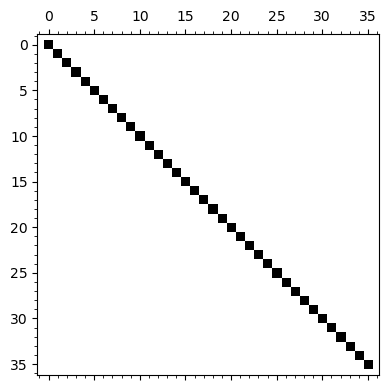

In [39]:
# scratch - visualize the vertices basis. Should look like the identity matrix.
matrix_plot([list(v) for v in vertices_dict.values()])

### Weights for Short and Long Edges

In [ ]:
# Weights
weights_dict = {}
for t in range(M.num_tetrahedra()):
    weights_dict.update({
        'a{0}01'.format(t) : {'v{0}02'.format(t): 1, 'v{0}03'.format(t): -1},
        'a{0}02'.format(t) : {'v{0}03'.format(t): 1, 'v{0}01'.format(t): -1},
        'a{0}03'.format(t) : {'v{0}01'.format(t): 1, 'v{0}02'.format(t): -1},
        'a{0}10'.format(t) : {'v{0}13'.format(t): 1, 'v{0}12'.format(t): -1},
        'a{0}13'.format(t) : {'v{0}12'.format(t): 1, 'v{0}10'.format(t): -1},
        'a{0}12'.format(t) : {'v{0}10'.format(t): 1, 'v{0}13'.format(t): -1},
        'a{0}20'.format(t) : {'v{0}21'.format(t): 1, 'v{0}23'.format(t): -1},
        'a{0}21'.format(t) : {'v{0}23'.format(t): 1, 'v{0}20'.format(t): -1},
        'a{0}23'.format(t) : {'v{0}20'.format(t): 1, 'v{0}21'.format(t): -1},
        'a{0}30'.format(t) : {'v{0}32'.format(t): 1, 'v{0}31'.format(t): -1},
        'a{0}32'.format(t) : {'v{0}31'.format(t): 1, 'v{0}30'.format(t): -1},
        'a{0}31'.format(t) : {'v{0}30'.format(t): 1, 'v{0}32'.format(t): -1}
    })
    
    weights_dict.update({
        'A{0}01'.format(t) : {'v{0}01'.format(t): 1, 'v{0}10'.format(t): 1},
        'A{0}02'.format(t) : {'v{0}02'.format(t): 1, 'v{0}20'.format(t): 1},
        'A{0}03'.format(t) : {'v{0}03'.format(t): 1, 'v{0}30'.format(t): 1},
        'A{0}12'.format(t) : {'v{0}12'.format(t): 1, 'v{0}21'.format(t): 1},
        'A{0}13'.format(t) : {'v{0}13'.format(t): 1, 'v{0}31'.format(t): 1},
        'A{0}23'.format(t) : {'v{0}23'.format(t): 1, 'v{0}32'.format(t): 1},
    })
    


### Threads and Gluing Data
Including weights and lattice coordinates for threads

In [ ]:
def get_short_edges_in_face(tet,face):
    """
    Returns a list of the short edges contained in a specified face.

    Parameters:
    tet (Integer) - index of the tetrahedron containing the face.
    face (Integer) - index of the face.

    Returns:
    list of str - list of short edges contained in the face.
    """
    edge_indices = [0,1,2,3]
    edge_indices.remove(face)
    return ["a{0}{1}{2}".format(tet,i,face) for i in edge_indices]

def get_long_edges_in_face(tet,face):
    """
    Returns a list of the long edges contained in a specified face.

    Parameters:
    tet (Integer) - index of the tetrahedron containing the face.
    face (Integer) - index of the face.

    Returns:
    list of str - list of long edges contained in the face.
    """
    indices = [0,1,2,3]
    indices.remove(face)
    return ["A{0}{1}{2}".format(tet,indices[i1],indices[i2]) for i1 in range(3) for i2 in range(i1+1,3)]   
        
        
    return ["A{0}{1}{2}".format(tet,i,face) for i in edge_indices]

def get_long_edges_in_tet(tet):
    """
    Returns a list of the long edges contained in a specified face.

    Parameters:
    tet (Integer) - index of the tetrahedron.

    Returns:
    list of str - list of long edges contained in the tet.
    """
    return [name.format(tet) for name in ['A{0}01','A{0}02', 'A{0}03','A{0}12','A{0}13','A{0}23']]
    
    
def get_local_thread_weights(tet,face):
    """
    Finds the weights for the threads that would glue this face to another.

    Parameters:
    tet (Integer) - index of the tetrahedron containing the face
    face (Integer) - index of the face inside the tetrehedron.

    Returns:
    dict {str : Integer} - gives the weights of the threads for each vertex in the face."""
    short_edges = get_short_edges_in_face(tet,face)
    local_thread_weights = {}
    for short_edge in short_edges:
        local_thread_weights.update({
            vertex: -weight for vertex,weight in weights_dict[short_edge].items()
        })

    return local_thread_weights


In [ ]:
# turn the gluing data into a dictionary.

def get_gluing_dict(M):
    """
    Reformats the gluing data from a snappy triangulation with n tetrahedra.

    Parameters:
    M (snappy.Triangulation)

    Returns
    dict - each item is a map:
        'r{i}' specifies which tetrahedrons the faces of the i-th tet ends up in.
        's{i}{j}' specifies the gluing map for the j-th face of the i-th tet.
    """
    gluing_data = M._get_tetrahedra_gluing_data()
    gluing_dict = {}
    for t in range(M.num_tetrahedra()):
        gluing_dict.update({"r{0}".format(t) : gluing_data[t][0] })
        for f in range(4):
            gluing_dict.update({"s{0}{1}".format(t,f) : gluing_data[t][1][f]})
            
    return gluing_dict



# This list isn't used - it's replaced by get_thread_weights_dict.
"""
thread_endpoints = []
for t in range(3):
    for f in range(4):
        second_index = [0,1,2,3]
        second_index.remove(f)
        face_perm = gluing_dict["s{0}{1}".format(t,f)]
        for i2 in second_index:
            third_index = second_index.copy()
            third_index.remove(i2)
            for i3 in third_index:
                local_vertex = "v{0}{1}{2}".format(t,i2,i3)
                distant_vertex = "v{0}{1}{2}".format(
                    gluing_dict["r{0}".format(t)][f],
                    face_perm[i2],
                    face_perm[i3]
                )
                thread_endpoints.append({local_vertex, distant_vertex}) if thread_endpoints.count({local_vertex,distant_vertex}) == 0 else True
""";

In [90]:
# checks - are there self gluings?

tet_gluings = {k:v for k,v in get_gluing_dict(M).items() if k[0] == 'r'}
for k,v in tet_gluings.items():
    this_tet = int(k[1:])
    if v.count(this_tet) != 0:
        print("Tet {0} is self-glued!".format(this_tet))

In [ ]:
# This could be more beautiful.
def get_thread_weights_dict(M):
    """
    Finds the weights_dict for the threads, based on a snappy Triangulation.
    
    Parameters:
    M (snappy.Triangulation)
    
    Returns:
    dict of the form {str: vector} - gives the weights of the T-actions for the threads.
    """
    gluing_dict = get_gluing_dict(M)
    thread_weights_dict = {}
    for t in range(M.num_tetrahedra()):
        for f in range(4):
            face_perm = gluing_dict["s{0}{1}".format(t,f)]
            local_thread_weights = get_local_thread_weights(t,f)
            # add threads based on where they start. i.e. where they have weight 1.
            starting_here = list(filter(lambda k : local_thread_weights[k] == 1, local_thread_weights.keys()))
            for local_vertex in starting_here:
                distant_vertex = "v{0}{1}{2}".format(
                    gluing_dict["r{0}".format(t)][f],
                    face_perm[Integer(local_vertex[-2])],
                    face_perm[Integer(local_vertex[-1])]
                )
                thread_weights_dict.update({
                    "x{0}_{1}".format(local_vertex[1:], distant_vertex[1:]) : {local_vertex: 1, distant_vertex: -1}   
                })

    return thread_weights_dict


# Add thread weights to the big weights dictionary.
weights_dict.update(get_thread_weights_dict(M))

In [91]:
weights_dict

{'a001': {'v002': 1, 'v003': -1},
 'a002': {'v003': 1, 'v001': -1},
 'a003': {'v001': 1, 'v002': -1},
 'a010': {'v013': 1, 'v012': -1},
 'a013': {'v012': 1, 'v010': -1},
 'a012': {'v010': 1, 'v013': -1},
 'a020': {'v021': 1, 'v023': -1},
 'a021': {'v023': 1, 'v020': -1},
 'a023': {'v020': 1, 'v021': -1},
 'a030': {'v032': 1, 'v031': -1},
 'a032': {'v031': 1, 'v030': -1},
 'a031': {'v030': 1, 'v032': -1},
 'A001': {'v001': 1, 'v010': 1},
 'A002': {'v002': 1, 'v020': 1},
 'A003': {'v003': 1, 'v030': 1},
 'A012': {'v012': 1, 'v021': 1},
 'A013': {'v013': 1, 'v031': 1},
 'A023': {'v023': 1, 'v032': 1},
 'a101': {'v102': 1, 'v103': -1},
 'a102': {'v103': 1, 'v101': -1},
 'a103': {'v101': 1, 'v102': -1},
 'a110': {'v113': 1, 'v112': -1},
 'a113': {'v112': 1, 'v110': -1},
 'a112': {'v110': 1, 'v113': -1},
 'a120': {'v121': 1, 'v123': -1},
 'a121': {'v123': 1, 'v120': -1},
 'a123': {'v120': 1, 'v121': -1},
 'a130': {'v132': 1, 'v131': -1},
 'a132': {'v131': 1, 'v130': -1},
 'a131': {'v130': 1,

#### Lattice Coordinates for Threads

In [ ]:
def add_thread_lattice_coordinates(M,gens_dict,weights_dict):
    """ Adds the threads to the gens_dict.
    Assumes the the thread weights have already been added. Modifies gens_dict.
    
    Parameters:
    M (snappy.Triangulation()) - the triangulated knot complement
    gens_dict (dict {str: vector}) - the lattice coordinates of the generators
    weights_dict (dict {str: vector})- the weights of the generators 
    """
    num_tet = M.num_tetrahedra()
    thread_names = [k for k in weights_dict.keys() if k[0] == 'x']
    for i in range(len(thread_names)):
        gens_dict.update({
            thread_names[i] : vector([0]*(1+18*num_tet+i) + [1] + [0]*(12*num_tet-i-1))
        })

add_thread_lattice_coordinates(M,gens_dict,weights_dict)

## Commutation Relations

### Relations for Short and Long Edges.

In [ ]:
# first do short edges around a puncture
omega_short_one_puncture = 2*matrix([
    [ 0, 1,-1],
    [-1, 0, 1],
    [ 1,-1, 0]
])
omega_short = matrix.block_diagonal([omega_short_one_puncture]*4)

# columns are At01, At02, At03, At12, At13, At23
omega_short_long = 2*matrix([
    [0,1,1,0,0,0],
    [1,0,1,0,0,0],
    [1,1,0,0,0,0],
    #
    [0,0,0,1,1,0],
    [1,0,0,1,0,0],
    [1,0,0,0,1,0],
    #
    [0,0,0,1,0,1],
    [0,1,0,0,0,1],
    [0,1,0,1,0,0],
    #
    [0,0,0,0,1,1],
    [0,0,1,0,1,0],
    [0,0,1,0,0,1]
])



# columns are short then long
omega_one_tet = block_matrix([
    [omega_short,omega_short_long],
    [-omega_short_long.transpose(),0]
])

In [ ]:
# SCRATCH
omega_one_tet

### Thread Relations

In [ ]:
def get_edges_adjacent_to_vertex(vertex,weights_dict):
    """
    Returns a list of generators with non-zero weight at a given vertex.
    
    Parameters:
    vertex (str) - the name of a vertex.
    weights_dict (dict) - the weights dictionary.
    
    Returns:
    list of strings - the names of all edges with non-zero weight at this vertex.
    """
    adjacent_edges = []
    for edge, weights in weights_dict.items():
        if vertex in weights and weights[vertex] != 0:
            adjacent_edges.append(edge)
            
    return adjacent_edges

def get_thread_relations(gens_dict,weights_dict):
    """
    Builds the part of the relations matrix concerning threads.
    """
    thread_names = list(filter(lambda k : k[0] == 'x', gens_dict.keys()))
    thread_relations = []
    
    for thread in thread_names:
        this_threads_relations = []
        for vertex,weight in weights_dict[thread].items():
            tmp_adjacent_edges = get_edges_adjacent_to_vertex(vertex,weights_dict)
            # don't add relations for this thread with itself. 
            tmp_adjacent_edges.remove(thread)
            for edge in tmp_adjacent_edges:
                # commutation relation is the same for all non-thread generators at this vertex.
                if edge[0] == 'x':
                    this_threads_relations.append(weight*gens_dict[edge])
                else:
                    this_threads_relations.append(-weight*gens_dict[edge])
        thread_relations.append(sum(this_threads_relations))
    
    return 2*matrix(thread_relations)




In [ ]:
#checks
thread_relations = get_thread_relations(gens_dict,weights_dict)
# split the thread relations into two parts, to help construct the full relations matrix.
omega_thread_non_thread = thread_relations[:,1:18*num_tet+1]
omega_thread_thread = thread_relations[:,18*num_tet+1:]

print(thread_relations[:,18*num_tet+1:].is_skew_symmetric())

thread_relations

### Full Relations

In [ ]:
# Get the relations matrix, then its kernel

def get_relations_matrix(M,gens_dict,weights_dict,omega_one_tet):
    """Constructs the full relations matrix.
    
    Parameters:
    M (snappy.Triangulation)
    gens_dict (dict)
    weights_dict (dict)
    omega_one_tet (Matrix)
    
    Returns:
    Matrix
    """
    num_tet = M.num_tetrahedra()
    thread_relations = get_thread_relations(gens_dict,weights_dict)
    
    omega_thread_non_thread = thread_relations[:,1:18*num_tet+1]
    omega_thread_thread = thread_relations[:,18*num_tet+1:]
    
    omega_with_q = block_diagonal_matrix(
        matrix([0]),
        block_matrix([
            [block_diagonal_matrix(*[omega_one_tet]*num_tet),-omega_thread_non_thread.transpose()],
            [omega_thread_non_thread,omega_thread_thread]
        ])
    )
    
    return omega_with_q

omega_with_q = get_relations_matrix(M,gens_dict,weights_dict,omega_one_tet)

kernel_41 = omega_with_q.kernel().basis()

Here are some sanity checks for the relations matrix:

In [ ]:
# checking that the keys are in the same order.
print("weights_dict and gens_dict have the same order:", list(weights_dict.keys())==list(gens_dict.keys())[1:])

print("relations matrix is skew symmetric:", omega_with_q.is_skew_symmetric())

print("Rank of the center:",omega_with_q.right_kernel_matrix().rank())

matrix_plot(omega_with_q)
#omega_with_q.rows()

## Lattices
- Makes the lattice for the whole quanutm torus
- Makes the sublattice of T-invariant elements
- Also makes the weight _matrix_ in this section.

In [ ]:
# Make the lattice.
lattice = FreeModule(ZZ, len(gens_dict['qrt2']))

In [ ]:
def get_weights_matrix(vertices_dict,weights_dict):
    """
    Builds the weights matrix. This is useful for finding invariant sublattices.
    
    Parameters:
    vertices_dict - dictionary {vertex name: vertex coordinate}
    weights_dict - dictionary {generator name : weight}
    
    Returns
    Matrix - the weights matrix. it's (number generators) x (number vertices)
    """
    # start off with qrt2 - this is weight zero.
    weights_list = [[0]*(len(vertices_dict.keys()))]
    
    for weights in weights_dict.values():
        weights_list.append(sum([
            weight*vector(vertices_dict[vertex]) for vertex,weight in weights.items()
        ]))

    return Matrix(weights_list)

def get_weights_from_names(names,gens_dict,weights_matrix,weight_format='coordinate'):
    """
    Gets the weight of a monomial.
    
    Parameters:
    names Dict - specifies powers of generators. {'gen':exponent}
    gens_dict Dict - translates between generator names and coordinates
    weights_matrix Matrix - gives the T-weights of generators
    
    weight_format string - either 'coordinate' or 'dict'. Defaults to 'coordinate'
    """
    weight_coord = weights_matrix.transpose()*names_to_lattice_coordinate(names,gens_dict)
    if weight_format == 'coordinate':
        return weight_coord
    else:
        return lattice_coord_to_dict(weight_coord,vertices_dict)

weights_matrix = get_weights_matrix(vertices_dict,weights_dict)
invariant_sublattice = weights_matrix.left_kernel()

In [ ]:
# Some checks.
print("T-invariant part is a sublattice of rank",invariant_sublattice.rank(),"Out of",len(gens_dict))
print("Basis for the T-invariant sub-lattice:")
show(matrix_plot(invariant_sublattice.basis_matrix()))
print("The Weight Matrix:")
show(matrix_plot(weights_matrix))

## Peripheral Curves

In [ ]:
def get_peripheral_curve_intersection_dict(M,curve='meridian'):
    """
    Turns the peripheral curve data from SnapPy into a dictionary,
    The values are the intersection number of the peripheral curve with the given edge.
    A positive intersection number means the curve is going into the short-edge triangle.
    
    Parameters:
    M snappy.Triangulation - the triangulation of a knot complement.
    curve string - either 'meridian' or 'longitude'
    
    Returns:
    dict - of the form {'short_edge': weight}. I'm not sure yet what the weights mean.
    """
    all_periph_data = M._get_cusp_indices_and_peripheral_curve_data()[1]
    data_start = {'meridian':0, 'longitude':2}
    
    curve_data = [all_periph_data[i] for i in range(data_start[curve],len(all_periph_data), 4)]

    return {'a{0}{1}{2}'.format(t,v,f):curve_data[t][4*v+f]
            for t in range(M.num_tetrahedra())
            for v in range(4)
            for f in range(4)
            if 0 != curve_data[t][4*v+f]
           }
    
def get_thread_going_to_vertex(vertex_name,gens_dict):
    """
    Returns the thread with weight -1 at the given vertex.
    """
    vertex_index = vertex_name[1:]
    threads_list = [k for k in gens_dict.keys() if k[0] == 'x' and k.split("_")[1] == vertex_index]
    assert len(threads_list) == 1
    return threads_list[0]

def get_peripheral_curve_monomial(M,gens_dict,vertices_dict,weights_dict,weights_matrix,curve='meridian',log_level='normal'):
    """
    Gets an expression for the peripheral curve of the triangulation in terms of generators.
    There are multiple correct answers. We find this one based on SnapPy's suggestion.
    
    Parameters:
    M snappy.Triangulation - the triangulation of a knot complement.
    gens_dict Dict - the dictionary of generators.
    vertices_dict Dict - the dictionary of vertices
    weights_dict Dict - the dictionary of weights for generators.
    weights_matrix Matrix - the matrix of weights for generators
    
    curve string - either 'meridian' or 'longitude'
    """
    
    
    intersection_dict = get_peripheral_curve_intersection_dict(M,curve=curve)
    
    #### First find the threads from the intersection dictionary.
    peripheral_curve_threads = {}
    
    vertices_for_positive_crossings = { # the weight +1 vertex for each short edge we cross positively.
        [vert for vert,weight in weights_dict[short_edge].items() if weight==1][0] : se_weight
        for short_edge,se_weight in intersection_dict.items() if se_weight > 0
    }
    peripheral_curve_threads.update({
        get_thread_going_to_vertex(v,gens_dict) : weight for v,weight in vertices_for_positive_crossings.items()
    })
    
    logger.debug("Threads in the {curve}: {threads}".format(curve=curve,threads=peripheral_curve_threads))
    #### Now we need to fill in the gaps with short edges.
    # Make a dictionary of all the short edges we'll need to include.
    peripheral_curve_short_edges = {}
    
    # we work based on the weights of the threads:
    peripheral_curve_thread_weights = get_weights_from_names(peripheral_curve_threads,gens_dict,weights_matrix,weight_format='dict')
    
    # work one boundary triangle at a time:
    for tet in range(M.num_tetrahedra()):
        for vertex in range(4):
            this_triangle_weights = {
                k:v for k,v in peripheral_curve_thread_weights.items() if k[:-1] == 'v{0}{1}'.format(tet,vertex)
            }
            if not this_triangle_weights == dict(): # if there's weight zero move on.
                logger.debug("Face {vertex} of Tetrahedra {tet} has non-zero weight: {weights}".format(tet=tet,vertex=vertex,weights=this_triangle_weights))
                local_short_edge_weights = {short_edge : weights_dict[short_edge] for short_edge in gens_dict.keys() if short_edge[:-1] == 'a{0}{1}'.format(tet,vertex)}
                for short_edge,se_weights in local_short_edge_weights.items():
                    if set(se_weights.keys()) == set(this_triangle_weights.keys()):
                        a_vertex = list(se_weights.keys())[0]
                        short_edge_power = -se_weights[a_vertex]*this_triangle_weights[a_vertex]
                        logger.debug("Adding {short_edge}^{power} to the curve.".format(short_edge=short_edge,power=short_edge_power))
                        old_short_edge_weight = peripheral_curve_short_edges.get(short_edge,0)
                        peripheral_curve_short_edges.update({short_edge:old_short_edge_weight+short_edge_power})


    curve_dict = (peripheral_curve_threads | peripheral_curve_short_edges)
    curve_weights = lattice_coord_to_dict(get_weights_from_names(curve_dict,gens_dict,weights_matrix),vertices_dict)
    if curve_weights != dict():
        logger.error("Curve has non-zero T-weights! {weights}".format(weights=curve_weights))
    return curve_dict
   
meridian = get_peripheral_curve_monomial(M,gens_dict,vertices_dict,weights_dict,weights_matrix,curve='meridian')
longitude = get_peripheral_curve_monomial(M,gens_dict,vertices_dict,weights_dict,weights_matrix,curve='longitude')

# checks!
logger.debug("meridian should have weight zero: "+ str(lattice_coord_to_dict(get_weights_from_names(meridian,gens_dict,weights_matrix),vertices_dict)))
logger.debug("longitude should have weight zero: "+ str(lattice_coord_to_dict(get_weights_from_names(longitude,gens_dict,weights_matrix),vertices_dict)))

logger.debug("Commutation relations: M*L = q^({0})L*M".format((matrix(names_to_lattice_coordinate(meridian,gens_dict))*omega_with_q*matrix(names_to_lattice_coordinate(longitude,gens_dict)).transpose())[0,0]/4))

# Constraints and Quotients

Any quotient of the form $M^{x} = 1$ in the quantum torus can be expressed in terms of the lattice as $x = 0$. We want to quotient by
1. Monodromy at each of the punctures
1. The gluing constraints, 6 from each face so 12*num_tetrahedron total
1. Monodromy around the long edge handles
1. The great circle relations, 1 from each tetrahedron so 2 total.

The first three types of relations are monomial. I expect to get a lattice of rank num_tetrahedron+2 once those are imposed. The last relation will have to be done in terms of the quantum torus, not the lattice.


## Constraints Lists

### T-Monodromy Around Punctures

In [ ]:
def get_T_monodromy_list(M,gens_dict):
    """
    Constructs the list of T-monodromy expressions. Assumes that gens_dict has the short edges in the right order.
    
    Parameters:
    M (snappy.Triangulation) - the triangulated knot complement
    gens_dict (dict {str:vector}) - the lattice coordinates for the generators of the skein algebra
    
    Returns:
    list of lists of strings - each element is a list of the short edges around a puncture.
    
    """
    num_tet = M.num_tetrahedra()
    # the short edges are listed in gens_dict in the right order.
    short_edge_names = list(filter(lambda name: name[0]=='a', gens_dict.keys()))
    T_monodromy_list = []
    for p in range(num_tet*4):
        T_monodromy_list.append({'qrt2':2} | {k:1 for k in short_edge_names[3*p:3*p+3]})
    
    return T_monodromy_list

T_monodromy_variable_names_list = get_T_monodromy_list(M,gens_dict)
T_monodromy_lattice_coordinate_list = [
    names_to_lattice_coordinate(v,gens_dict) for v in T_monodromy_variable_names_list
]

In [217]:
# Checks.

for coord in T_monodromy_lattice_coordinate_list:
    if not (matrix(coord)*weights_matrix).is_zero():
        print("Not Invariant:",coord)


### Gluing Relations

In [ ]:
def get_long_edge_gluing_relations_list(M,gens_dict):
    """
    Parameters:
    M (snappy.Triangulation) - the triangulated knot complement.
    gens_dict (dict {str:vector}) - the lattice coordinates for the generators of the skein algebra

    Returns
    list of dicts - gluing relations. keys are generators and values are their powers.
    """

    long_edge_gluing_relations_list = []
    
    threads_list = list(filter(lambda gen : gen[0] == 'x',gens_dict.keys()))
    th = threads_list[0]
    tmp_gluing_dict = {th:-1}
    
    index_reversal_map = lambda index : index[:-2] + ''.join(reversed(index[-2:]))
    index_sort_map = lambda index : index[:-2] + ''.join(sorted(index[-2:]))
    
    while threads_list:
        other_thread = "x{1}_{0}".format(*[index_reversal_map(index) for index in th[1:].split('_')])
        tmp_gluing_dict[other_thread] = 1
        
        long_edge_pos = "A" + index_sort_map(th[1:].split('_')[0])
        tmp_gluing_dict[long_edge_pos] = 1
        
        long_edge_neg = "A" + index_sort_map(th[1:].split('_')[1])
        tmp_gluing_dict[long_edge_neg] = -1
        
        long_edge_gluing_relations_list.append(tmp_gluing_dict)
        
        # remove these two threads so we don't check them again
        threads_list = list(set(threads_list) - set(tmp_gluing_dict.keys()))
        
        if threads_list == list():
            return long_edge_gluing_relations_list
        else:
            # on to the next one
            th = threads_list[0]
            tmp_gluing_dict = {th:-1}
            

long_edge_gluing_relations_list = get_long_edge_gluing_relations_list(M,gens_dict)

In [179]:
# Check that all relations are T-invariant, and incidentally that we've listed actual threads.
# It's working well if nothing is printed.

for constraint in long_edge_gluing_relations_list:
    lat_coord = names_to_lattice_coordinate(constraint,gens_dict)
    if not (lat_coord*weights_matrix).is_zero():
        print("Not Invariant!", lat_coord*weights_matrix)
        
#print(long_edge_gluing_relations_list)

In [ ]:
def get_short_edge_gluing_relations_list(M,weights_dict):
    """
    Constructs a the list of constraints inclured by gluing together short edges.
    
    Parameters:
    M snappy.Triangulation - the triangulated knot complement.
    weights_dict - the weights of edges. Used to find where edges start/end.
    
    Returns:
    list of lists of strings - elements are lists of generator names. Should be in the right order. 
    """
    gluing_data = get_gluing_dict(M)
    short_edge_gluing_relations_list = []
    
    for tet in range(num_tet):
        for face in range(4):
            new_tet = gluing_data['r{0}'.format(tet)][face]
            if new_tet <= tet: # avoid double-lisitng relations. will still double-list self-foldings.
                gluing_perm = gluing_data['s{0}{1}'.format(tet,face)]
                new_face = gluing_perm[face]
                for short_edge in get_short_edges_in_face(tet,face):
                    distant_short_edge = 'a{0}{1}{2}'.format(new_tet,gluing_perm[Integer(short_edge[-2])],new_face)

                    tmp_local_weights = weights_dict[short_edge]
                    local_starting_vertex = [vertex[1:] for vertex,weight in tmp_local_weights.items() if weight == -1][0]  
                    local_ending_vertex = [vertex[1:] for vertex,weight in tmp_local_weights.items() if weight == 1][0]  

                    tmp_distant_weights = weights_dict[distant_short_edge]
                    distant_starting_vertex = [vertex[1:] for vertex,weight in tmp_distant_weights.items() if weight == -1][0]  
                    distant_ending_vertex = [vertex[1:] for vertex,weight in tmp_distant_weights.items() if weight == 1][0]  

                    short_edge_gluing_relations_list.append({
                        'qrt2' : 2,
                        short_edge : 1,
                        'x{0}_{1}'.format(local_starting_vertex,distant_ending_vertex) : 1,
                        distant_short_edge : 1,
                        'x{0}_{1}'.format(distant_starting_vertex,local_ending_vertex) : 1
                    })
    return short_edge_gluing_relations_list

short_edge_gluing_relations_list = get_short_edge_gluing_relations_list(M,weights_dict)

In [1006]:
# Check that all relations are T-invariant, and incidentally that we've listed actual threads.
for constraint in short_edge_gluing_relations_list:
    if not (sum([gens_dict[edge] for edge in constraint])*weights_matrix).is_zero():
        print("Not Invariant!", constraint)


### Monodromy Around the Internal Handles
Because we glue close to but not quite up to the long edges, we have some extra handles on the surface that we'd like to do away with.

The idea right now is to work with something like a partial skein-module, which is what we get by restricting to the part of the moduli space where our local systems extend to the interior of these handles.

These relations will depend on the triangulation, but they're always of the general form will always be a set of monomials in the threads. If all faces are glued then each thread shows up in exactly one monomial.

In [ ]:
def get_internal_edge_monodromy(gens_dict):
    """Constructs expressions for the T-region monodromies around the 'extra handles'
    on the glued surface.
    
    Works based on the thread names. Assumes that the monodromies are each a cycle.
    if they cross themselves or something this probably won't work."""
    
    list_of_monodromies = []
    
    threads_list = [k for k in gens_dict.keys() if k[0] == 'x']
    th = threads_list[0]
    tmp_monodromy_dict = {'qrt2':2,th:1}

    while threads_list:
        th_end_vertex = th[1:].split('_')[1]
        next_thread = list(filter(lambda thread : thread[1:].split('_')[0] == th_end_vertex,threads_list))[0]

        if next_thread in tmp_monodromy_dict.keys():
            # we've closed the loop!
            list_of_monodromies.append(tmp_monodromy_dict)
            threads_list = list(set(threads_list) - set(tmp_monodromy_dict.keys()))
            if threads_list == list():
                return list_of_monodromies
            th = threads_list[0]
            tmp_monodromy_dict = {'qrt2':2,th:1}
        else:
            tmp_monodromy_dict.update({next_thread:1})
            th = next_thread
    
    
internal_edge_monodromy_list = get_internal_edge_monodromy(gens_dict)

In [100]:
# Checks!
print("Constraints should come in pairs of equal length. There should be {0} total.".format(2*M.num_tetrahedra()))
# 2t because there are 2t pairs of glued faces, t-1 of which don't increase the genus.
# so genus is g = 2t - (t-1) = t+1. We're interested in the T-region torus, so g-1 genus is killed using 2(g-1) = 2t constraints.
for m in internal_edge_monodromy_list:
    print(m)

# Check that all relations are T-invariant
for constraint in internal_edge_monodromy_list:
    if not (sum([gens_dict[edge] for edge in constraint])*weights_matrix).is_zero():
        logger.error("Not Invariant! " +str(constraint))

Constraints should come in pairs of equal length. There should be 4 total.
{'qrt2': 2, 'x012_113': 1, 'x113_003': 1, 'x003_112': 1, 'x112_013': 1, 'x013_103': 1, 'x103_012': 1}
{'qrt2': 2, 'x101_010': 1, 'x010_102': 1, 'x102_023': 1, 'x023_132': 1, 'x132_020': 1, 'x020_101': 1}
{'qrt2': 2, 'x123_032': 1, 'x032_120': 1, 'x120_001': 1, 'x001_110': 1, 'x110_002': 1, 'x002_123': 1}
{'qrt2': 2, 'x031_121': 1, 'x121_030': 1, 'x030_131': 1, 'x131_021': 1, 'x021_130': 1, 'x130_031': 1}


## Quotient Lattice
TODO - doesn't work for all T-region quotient bases. (Though I haven't come across a problematic example.)

In [ ]:
# Take the quotient!
quotient_lattice = invariant_sublattice.quotient(
    [names_to_lattice_coordinate(v,gens_dict) for v in
     internal_edge_monodromy_list
     + short_edge_gluing_relations_list
     + long_edge_gluing_relations_list
     + T_monodromy_variable_names_list
    ]
)

pi = quotient_lattice.coerce_map_from(quotient_lattice.V())


# Next build the quotient basis!

T_region_basis = matrix([pi(gens_dict['qrt2']), pi(names_to_lattice_coordinate(meridian,gens_dict)), pi(names_to_lattice_coordinate(longitude,gens_dict))])

T_region_minor_indexes = [(i,j,k)
           for i in range(T_region_basis.ncols())
           for j in range(i+1,T_region_basis.ncols())
           for k in range(j+1,T_region_basis.ncols())
          ]

minors = T_region_basis.minors(3)
non_zero_minors = {}
for i in range(len(minors)):
    if minors[i] == 1: # we only need one minor
        non_zero_rows = set(range(T_region_basis.ncols()))-set(T_region_minor_indexes[i])
        num_new_rows = len(non_zero_rows)
        non_zero_entries = zip(range(num_new_rows),non_zero_rows)
        new_rows = zero_matrix(ZZ,nrows=num_new_rows, ncols=T_region_basis.ncols())
        for entry in non_zero_entries:
            new_rows[entry] = 1
        break
    # store all non-zero minors in case we need to use extended Euclidean algorithm.
    if minors[i] != 0: 
        # TODO - implement this using xgcd.
        non_zero_minors.update({T_region_minor_indexes[i]:minors[i]})


quotient_basis = block_matrix([[T_region_basis],[new_rows]]).transpose()

In [101]:
# Checks

non_long_edge_generators = list(filter(lambda gen : gen[0] != 'A',gens_dict.keys()))
non_long_edge_lattice = Matrix([gens_dict[gen] for gen in non_long_edge_generators]).row_module().intersection(invariant_sublattice)
T_region_quotient_lattice = non_long_edge_lattice.quotient(
    [names_to_lattice_coordinate(v,gens_dict) for v in
     internal_edge_monodromy_list
     + short_edge_gluing_relations_list
     + T_monodromy_variable_names_list
    ]
)

print("Lattice rank:", lattice.rank())
print("T-region sublattice of that is rank:", non_long_edge_lattice.intersection(lattice).rank())
print("T-invariant lattice is rank",invariant_sublattice.rank())

# Checks -
print("Including q, the quotient lattice should be rank: {0}. It's rank {1}".format(M.num_tetrahedra()+2, quotient_lattice.ngens()))
print("The T-region quotient lattice has", T_region_quotient_lattice.ngens(),"generators")

print("Quotient basis matrix should have determinent 1. Det: {}".format(quotient_basis.det()))

print("\nThe generators:")
# what do these generators look like?
for g in quotient_lattice.gens():
    print(lattice_coord_to_dict(g.lift(),gens_dict))
    
print("\nT-region generators:")
for g in T_region_quotient_lattice.gens():
    print(lattice_coord_to_dict(g.lift(),gens_dict))
    

Lattice rank: 61
T-region sublattice of that is rank: 26
T-invariant lattice is rank 37
Including q, the quotient lattice should be rank: 4. It's rank 4
The T-region quotient lattice has 3 generators
Quotient basis matrix should have determinent 1. Det: -1

The generators:
{'qrt2': 1}
{'a001': 1, 'a131': -1, 'A113': 1, 'A123': -1, 'x002_123': -1, 'x021_130': -1, 'x131_021': -1, 'x113_003': -1}
{'a002': 1, 'a131': 1, 'A113': -1, 'A123': 1, 'x001_110': 1, 'x002_123': 1, 'x021_130': 1, 'x131_021': 1, 'x113_003': 1, 'x110_002': 1}
{'a013': 1, 'a123': -1, 'A113': -1, 'A123': 1, 'x003_112': 1, 'x020_101': -1, 'x001_110': 1, 'x013_103': 1, 'x030_131': -1, 'x002_123': 1, 'x112_013': 1, 'x103_012': 1, 'x120_001': 1, 'x132_020': -1, 'x101_010': -1, 'x113_003': 1, 'x110_002': 1, 'x121_030': -1}

T-region generators:
{'qrt2': 1}
{'a001': 1, 'a112': -1, 'x113_003': -1, 'x110_002': 1}
{'a013': 1, 'a112': 1, 'a123': -1, 'a131': -1, 'x003_112': 1, 'x020_101': -1, 'x001_110': 1, 'x013_103': 1, 'x030_13

In [226]:
# Looking at the relations.

relations_matrix = matrix([names_to_lattice_coordinate(v,gens_dict) for v in
     internal_edge_monodromy_list
     + short_edge_gluing_relations_list
     + long_edge_gluing_relations_list
     + T_monodromy_variable_names_list
    ])

print("The relations matrix has dimension {0} and rank {1}.".format(relations_matrix.dimensions(),relations_matrix.rank()))

print("If any of these are not 1, there's torsion:")
smith_form = relations_matrix.smith_form()[0]
print([smith_form[i,i] for i in range(smith_form.rank())])


The relations matrix has dimension (54, 91) and rank 50.
If any of these are not 1, there's torsion:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## Take the quotient of the Ring (Experimental)
Here I first pass to a polynomial ring, then take the quotient.

In [ ]:
skein_ring = PolynomialRing(ZZ, list(gens_dict.keys()))
long_edge_names = [arc for arc in gens_dict.keys() if arc[0] == 'A']
localized_skein_rign = skein_ring.localization(tuple(skein_ring(g) for g in long_edge_names))

### Convert contraints to polynomials
This gives me a polynomial algebra that's too big to work with.

In [ ]:
def dict_to_polynomial(the_dict,the_ring):
    positive_terms = '*'.join([k for k,v in the_dict.items() if v > 0])
    negative_terms = '*'.join(['1']+[k for k,v in the_dict.items() if v < 0])
    return the_ring(positive_terms+' - '+negative_terms)

generic_bird_head_polynomial = 'qrt2^4*A{t}03*a{t}32*a{t}01*A{t}12*a{t}23*a{t}10*(a{t}03*a{t}12*a{t}21*a{t}30) + A{t}01*A{t}23  - qrt2^2*A{t}13*A{t}02*(a{t}03*a{t}12*a{t}21*a{t}30)' 

bird_head_contraints = [skein_ring(generic_bird_head_polynomial.format(t=tet)) for tet in range(M.num_tetrahedra())]
polynomial_constraints = [dict_to_polynomial(constraint,skein_ring) for constraint in internal_edge_monodromy_list + short_edge_gluing_relations_list + long_edge_gluing_relations_list + T_monodromy_variable_names_list]

In [ ]:
I = skein_ring.ideal(bird_head_contraints+polynomial_constraints)

# Kernel of the Skein Module

In [ ]:
def fix_long_edge_indices(dictionary):
    """
    Fixes the indices on the long edge names in a dictionary.
    These sometimes end up being backwards, e.g. A020 instead of A002.
    NOTE: this won't handle the situation where a dictionary has the same edge under two different names.
    
    Parameters:
    dictionary (dict) - the dictionary that needs fixing.
    
    Returns:
    dict - the fixed dictionary.
    
    """
    index_sort_map = lambda index : index[:-2] + ''.join(sorted(index[-2:]))
    
    return {index_sort_map(k) : dictionary[k] for k in dictionary.keys() if k[0] == 'A'} | {k : v for k,v in dictionary.items() if k[0] != 'A'}

## The Bird Heads
There are 12 'untwisted' bird heads from the 12 orientation preserving permutations on the four vertices.

There are likely many others that wind around the various vertices. I'm hoping that those are in the ideal generated by the simple ones.

In [ ]:
def get_bird_head_coords(gens_dict, relations, tet=0,ll=0,ii=1,jj=2,kk=3):
    """Gets exact coordinates for a bird head, based on the indices of the punctures it intertwines and which tetrahedra it's on.
    
    Bird Head has weight 2 at puncture l and encircles the puncture i in the diagram below:
    
       j       
     ╱ | ╲     
    l ─── i    
     ╲ | ╱     
       k       
        
    Parameters:
        gens_dict (dict) -- dictionary relating variable names to lattice coordinates.
        relations (matrix) - relations for the quantum tori.
        tet (int) - the index of the tetrahedron encircled by the great circle.
        ii, jj , kk (int) - indices saying which punctures the bird head connects. defaults to 1,2,3. See ascii art above.
    
    Returns:
        list of vectors - coordinates for the specified bird head.
    """
    
    # Generic expressions were found by hand.
    # The bird head, computed using resolutions
    # NOTE - the term with A02 A13 should have its coefficient multiplied by -1. This is handled later.
    generic_bird_head = [ # the 10 term is zero.
        {'qrt2':2, 'a{t}{l}{j}':-1, 'A{t}{l}{i}':1, 'a{t}{i}{k}':1, 'A{t}{l}{k}':1, 'a{t}{k}{j}':1, 'A{t}{i}{j}':1, 'a{t}{i}{l}':1}, # 00
        {'q':0, 'A{t}{l}{i}':2, 'a{t}{i}{k}':1, 'a{t}{i}{j}':-1, 'a{t}{j}{l}':1, 'A{t}{j}{k}':1, 'a{t}{k}{l}':-1}, # 01
        {'qrt2':-2, 'a{t}{l}{k}':1, 'A{t}{l}{j}':1, 'a{t}{j}{k}':-1, 'A{t}{l}{i}':1, 'a{t}{i}{j}':-1, 'A{t}{i}{k}':1, 'a{t}{i}{l}':-1} # 11
    ]
    
    # The product of long edges used to compute the bird head in cluster coordinates.
    generic_scaffolding = {'A{t}{i}{j}':-1, 'A{t}{i}{k}':-1}
    
    generic_weight_factor = {'A{t}{j}{k}':1, 'a{t}{j}{i}':-1, 'A{t}{l}{j}':-1, 'a{t}{l}{k}':-1, 'a{t}{l}{j}':1, 'A{t}{l}{k}':-1, 'a{t}{k}{i}':1}
    
    # Multiply by an invertible element to bring the T-weights all to zero.
    specific_weight_factor = fix_long_edge_indices({k.format(t=tet,l=ll,i=ii,j=jj,k=kk) : v for k,v in generic_weight_factor.items()})
    
    gens_dict_with_q = {**gens_dict,'q':2*gens_dict['qrt2']}
    
    specific_bird_head = [
        fix_long_edge_indices({ k.format(t=tet,l=ll,i=ii,j=jj,k=kk) : v for k,v in monomial.items()}) for monomial in generic_bird_head
    ]
    
    specific_scaffolding =  fix_long_edge_indices({ k.format(t=tet,l=ll,i=ii,j=jj,k=kk) : v for k,v in generic_scaffolding.items()})
    
    unscaled_bird_head= [
        product_from_names(specific_weight_factor,specific_scaffolding,monomial,relations=relations,gens_dict=gens_dict_with_q)
        for monomial in specific_bird_head
    ]
    
    return unscaled_bird_head
    #return [product_from_names(specific_weight_factor,monomial,gens_dict=gens_dict,relations=relations) for monomial in unscaled_bird_head]

## Kernel for the Knot Complement

In [ ]:
quotient_ring = LaurentPolynomialRing(QQ,['qrt2','m','l'] + ['w{0}'.format(i-3) for i in range(3,quotient_lattice.ngens())])
polynomial_ring = PolynomialRing(QQ,['qrt2','l','m'] + ['w{0}'.format(i-3) for i in range(3,quotient_lattice.ngens())])

change_of_basis_matrix = quotient_basis.det()*quotient_basis.inverse()

In [ ]:
# Checks!

# I'm assuming that the first generator in the quotient ring is just qrt2. I can check that here.
print("Check the assumption that qrt2 is sent to (1,0,..,0):")
print(pi(gens_dict['qrt2']))

In [ ]:
qrt2 = quotient_ring('qrt2')
qdim2 = -qrt2^2 + -qrt2^-2

In [ ]:
generic_crossing_relation = [ # this equals 1.
    {'qrt2':1, 'A{t}13':-1, 'A{t}02':-1, 'A{t}03':1, 'a{t}32':1, 'a{t}01':1, 'A{t}12':1, 'a{t}23':1, 'a{t}10':1},
    {'qrt2':-1, 'A{t}13':-1, 'A{t}02':-1, 'A{t}01':1, 'a{t}03':-1,'a{t}12':-1, 'A{t}23':1, 'a{t}21':-1, 'a{t}30':-1}
]

crossing_relations = []
for tt in range(M.num_tetrahedra()):
    specific_crossing_relation = sum([
        lattice_coord_to_ring_element(change_of_basis_matrix*vector(pi(names_to_lattice_coordinate({k.format(t=tt) : v 
            for k,v in monomial.items()},gens_dict))),quotient_ring) 
                for monomial in generic_crossing_relation
    ]).subs({quotient_ring('qrt2'):-1})-1
    crossing_relations.append(polynomial_ring(clear_denominator(specific_crossing_relation)))
    
print("Relations:\n",crossing_relations)
A_poly_candidate = polynomial_ring.ideal(crossing_relations).elimination_ideal([polynomial_ring(str(g)) for g in quotient_ring.gens()[-M.num_tetrahedra()+1:]]).gens()[0]
print("A-polynomial:\n",A_poly_candidate.factor())

### Different bases for the quotient lattice

In [238]:
def get_A_polynomial_using_basis(basis_matrix,gens_dict,print_steps=True):
    #TODO - this takes a lot of ambient parameters.
    generic_crossing_relation = [ # this equals 1.
        {'qrt2':1, 'A{t}13':-1, 'A{t}02':-1, 'A{t}03':1, 'a{t}32':1, 'a{t}01':1, 'A{t}12':1, 'a{t}23':1, 'a{t}10':1},
        {'qrt2':-1, 'A{t}13':-1, 'A{t}02':-1, 'A{t}01':1, 'a{t}03':-1,'a{t}12':-1, 'A{t}23':1, 'a{t}21':-1, 'a{t}30':-1}
    ]
    tmp_change_of_basis_matrix = basis_matrix.det()*basis_matrix.inverse()
    crossing_relations = []
    for tt in range(M.num_tetrahedra()):
        specific_crossing_relation = sum([
            lattice_coord_to_ring_element(tmp_change_of_basis_matrix*vector(pi(names_to_lattice_coordinate({k.format(t=tt) : v 
                for k,v in monomial.items()},gens_dict))),quotient_ring) 
                    for monomial in generic_crossing_relation
        ]).subs({quotient_ring('qrt2'):-1})-1
        crossing_relations.append(polynomial_ring(clear_denominator(specific_crossing_relation)))
    
    
    A_poly_candidate = polynomial_ring.ideal(crossing_relations).elimination_ideal([polynomial_ring(str(g)) for g in quotient_ring.gens()[-M.num_tetrahedra()+1:]]).gens()[0]
    
    if print_steps:
        print("Relations:\n",crossing_relations)
        print("A-polynomial:\n",A_poly_candidate.factor())
        
    return A_poly_candidate
    
    
A = get_A_polynomial_using_basis(test_basis,gens_dict)

NameError: name 'test_basis' is not defined

In [219]:
print("m is ", pi(names_to_lattice_coordinate(meridian,gens_dict)),", l is ",pi(names_to_lattice_coordinate(longitude,gens_dict)))

m is  (-6, 0, 0, 0, -1, 0, 0) , l is  (-18, 1, 0, 0, -2, -1, 0)


In [259]:
monomial_transformation_matrix = GL(M.num_tetrahedra()+2,ZZ)([
    [1,0,0,0,0],
    [0,1,0,1,0],
    [0,0,1,-1,0],
    [0,0,0,1,-1],
    [0,0,0,0,-1]
]).matrix()

for ii in range(M.num_tetrahedra()+2):
    print(
        lattice_coord_to_ring_element(vector(identity_matrix(M.num_tetrahedra()+2)[:,ii]),quotient_ring),
        "goes to",
        lattice_coord_to_ring_element(monomial_transformation_matrix*vector(identity_matrix(M.num_tetrahedra()+2)[:,ii]),quotient_ring)
    )

get_A_polynomial_using_basis(monomial_transformation_matrix*quotient_basis*monomial_transformation_matrix.inverse(),gens_dict)


qrt2 goes to qrt2
m goes to m
l goes to l
w0 goes to m*l^-1*w0
w1 goes to w0^-1*w1^-1
Relations:
 [-l*m^2*w0*w1 - l^2*m^2 - w0^2*w1, -l^5*m - l^4*m*w0 - w0^4*w1, -l^2*m - m^2*w0 - l]
A-polynomial:
 (-1) * l^4 * (-l^2*m^6 + l*m^7 + 2*l^3*m^3 - l^2*m^4 - l*m^5 + 5*l^2*m^2 - l*m^3 + 4*l*m + 1)


l^6*m^6 - l^5*m^7 - 2*l^7*m^3 + l^6*m^4 + l^5*m^5 - 5*l^6*m^2 + l^5*m^3 - 4*l^5*m - l^4

### Computations with kernel elements - NOT UPDATED

In [ ]:
### Generators for the glued surface! NOT UPDATED

# we want to generate the lattice and have determinant +1 for the basis matrix
extra_gen = list_to_module_element([0,-1,0],full_quotient_41).lift()
# some sanity checks on the extra generator:
if not (weights_41*vector(extra_gen)).is_zero():
    print("weight of extra generator:",weights_41*extra_gen)

print("extra_gen in quotient:",pi(extra_gen))

m_gen = vector(dict_monomial_to_list(
    multiply_lattice_monomials(
        *[new_gens(edge) for edge in ['x1','al03','al13','y1']],
        relations=omega_41_with_q
    )))

if not (weights_41*vector(m_gen)).is_zero():
    print("weight of m:",weights_41*m_gen)
    
print("m_gen in quotient:",pi(m_gen))

l_gen = dict_monomial_to_list(scale_polynomial(
    multiply_lattice_monomials(
        *[new_gens(edge) for edge in ['z2','al23','al13','y2','w5','z5','be21','be01','x6','z3','be20','be30','y3','x3','be03','be23']],
        relations=omega_41_with_q
    ),q^(-1/2)))
if not (weights_41*vector(l_gen)).is_zero():
    print("weight of l:",weights_41*vector(l_gen))
    
print("l_gen in quotient:",pi(l_gen))


favorite_basis_matrix = matrix([
    pi(m_gen),
    pi(l_gen),
    pi(extra_gen)
]).transpose()

if favorite_basis_matrix.determinant() != 1:
    print("WARNING: favorite_basis_matrix has determinant:",favorite_basis_matrix.determinant())
    
    
print("Commutation Relations in the quotient. These are in terms of q^(1/2).") # this is assuming that the quotient preserves the commutation relations.
omega_quotient = matrix([m_gen,l_gen,extra_gen])*omega_41_with_q*matrix([m_gen,l_gen,extra_gen]).transpose()
print(omega_quotient)

tmp_omega = (omega_41_with_q*matrix([m_gen,l_gen]).transpose())
#TODO - is there something that commutes with the m and l that I could use as the third generator?

In [ ]:
m_gen

In [ ]:
Qq.<qrt4> = FractionField(QQ['qrt4'])
var('q')
q = qrt4^4

quotient_free_algebra = FreeAlgebra(Qq,['m','l','g'])
quotient_poly_algebra = LaurentPolynomialRing(Qq,['m','l','g'])
classical_poly_algebra = LaurentPolynomialRing(QQ,['m','l','g'])
quotient_lex_order = ['m','l','g']

# Add -q^(1/2) - q^(-1/2) and turn into an element of the laurent polynomial ring.
print("Circle A:")
relation_A = quotient_poly_algebra.sum([
    quotient_poly_algebra(v)*quotient_poly_algebra.monomial(*k) for k,v in great_circle_quot_A.items()
]+[-qrt4^2 + -qrt4^(-2)])
pretty_print(relation_A)

print("Circle B:")
relation_B = quotient_poly_algebra.sum([
    quotient_poly_algebra(v)*quotient_poly_algebra.monomial(*k) for k,v in great_circle_quot_B.items()
]+[-qrt4^2 - qrt4^(-2)])
pretty_print(relation_B)

# ideal:

relations_ideal = quotient_poly_algebra.ideal([relation_A,relation_B])

## Set q->1 to get the classical expression.  - NOT UPDATED

In [ ]:
# I want to compare to the q=1 case.
f = Qq.hom(1,QQ) # map sending qrt4 -> 1.

classical_relation_A = relation_A.map_coefficients(f)
    
classical_relation_B = relation_B.map_coefficients(f)

print("Classical relations:")
pretty_print(classical_relation_A)
pretty_print(classical_relation_B)

## Searching for the A-polynomial - scratch  - NOT UPDATED

In [ ]:
# short names for convenience
r1 = classical_relation_A
r2 = classical_relation_B

pretty_print(r1.factor())
pretty_print(r2.factor())

classical_poly_algebra.ideal([r1,r2]).groebner_basis()

In [ ]:
# Check that all the terms in the great circles are invariant.
for k in great_circle_A.keys():
    if not (weights_41*matrix(k).transpose()).is_zero():
        print("Not invariant:", k)
        
for k in great_circle_B.keys():
    if not (weights_41*matrix(k).transpose()).is_zero():
        print("Not invariant:", k)

In [ ]:
#import sage.rings.polynomial.laurent_polynomial_ideal
#TODO: Figure out how to make ideals in a laurent polynomial ring!
Rquot.<M,L,G> = PolynomialRing(QQ,3) # Order of variables here informs the Groebner basis.
M,L,G = var('M','L','G')

In [ ]:
# I'm adding 2 since the great circles should be set to q^(1/2)+q^(-1/2)
# and we set q^(1/2) to -1. 
#r1 = 2 + q^(-1/2)*M*G + (1+q^(1/2))*M^(-1)*L^(-1) + q*M^(-3)*L^(-2)*G^(-1) + q^2*M^(-1)*G^(-1) + (q^(5/2)+q^(1/2))*M^(-2)*L^(-1)*G^(-1)     
#r1rescaled = (r1.subs(qrt4=i)*G).collect(G)
#r2 = 2 + q^(-1/2)*M^(-3)*G + (1+q^(1/2))*L*G + q*M^(3)*L^(2)*G^(1) + q^2*M^(3)*G^(-1) + (q^(5/2)+q^(1/2))*M^(3)*L^(1)    
#r2rescaled = (r2.subs(qrt4=i)*G).collect(G)

r1 = q^(-1/2) + (1+q^(1/2))*L*G + q*L^2*G^2 + q^2*M^2*L^4*G^2 + (q^(5/2)+q^(1/2))*M*L^3*G^2 - (q^(1/2)+q^(-1/2))*M*L^2*G
r2 = q^(-1/2) + (q+q^(3/2))*M^3*L + q^3*M^6*L^2 + q^2*M^10*L^4*G^2 + (q^(7/2)+q^(3/2))*M^8*L^3*G - (q^(1/2)+q^(-1/2))*M^5*L^2*G

r1_comm = r1.subs(qrt4=i).collect(G)
r2_comm = r2.subs(qrt4=i).collect(G)

pretty_print(r1_comm)
pretty_print(r2_comm)


#r1 = -M^4*L^2*G^2 + 0 + 1 + M^2*L^2 -2*M*L
#r2 = -G^2 + M^6*L^2*G^2 + M^6 -2*M^6*L*G

a2 = r1_comm.coefficient(G,2)
a1 = r1_comm.coefficient(G,1)
a0 = r1_comm.coefficient(G,0)

b2 = r2_comm.coefficient(G,2)
b1 = r2_comm.coefficient(G,1)
b0 = r2_comm.coefficient(G,0)

#dict_to_free_algebra_element(great_circle_quot_A,lex_order=['M','L','G'],free_algebra=Rquot)
#dict_to_free_algebra_element(great_circle_quot_B,lex_order=['M','L','G'],free_algebra=Rquot)
#Iquot.groebner_basis()
Apoly = L^2*M^4 + L*(-M^8+M^6+2*M^4+M^2-1)+M^4
#Aideal = Rquot.ideal(L^2*M^4 + L*(-M^8+M^6+2*M^4+M^2-1)+M^4)
pretty_print(Apoly)

In [ ]:
r1tilde = a2*(b2*a0*b1^(-1)*a2^(-1) - b0*b1^(-1))^2 + a0

pretty_print(r1tilde.collect(M))
pretty_print(r1tilde.collect(L).factor())

In [ ]:
# Can we quotient first?
quotient_first_41 = (ZZ^(60)).quotient(gluing_constraints_41+monodromy_constraints_41)

# weights in the quotient: project each row then make them into a new matrix.
TMP_weights_in_quotient_41 = []
for r in weights_41.rows():
    TMP_weights_in_quotient_41.append(list(quotient_first_41.coordinate_vector(r)))
    
weights_in_quotient_41 = matrix(TMP_weights_in_quotient_41)
print("Rank of the weight function in the quotient:",weights_in_quotient_41.rank())

# now take the invariants. We guess that this is rank 3.
#TODO: Figure out why this has rank 5. Also, figure out what rank the quotient should be.
invariants_in_quotient_41 = weights_in_quotient_41.right_kernel(basis='LLL')

In [ ]:
# Looking at redundant constraints.
print("The",len(monodromy_constraints_41),"monodromy constraints span a sublattice of rank",(ZZ^(60)).span(monodromy_constraints_41).dimension())
print("The",len(gluing_constraints_41),"gluing constraints span a sublattice of rank",(ZZ^(60)).span(gluing_constraints_41).dimension())
print("Together, they span a space of dimension",(ZZ^(60)).span(gluing_constraints_41+monodromy_constraints_41).dimension())
print("ngens: Over QQ, for the quotient with all T-gates open:",(QQ^(60)).quotient(gluing_constraints_41+monodromy_constraints_41).ngens())
print("ngens: Over ZZ, for the quotient with all T-gates open:",(ZZ^(60)).quotient(gluing_constraints_41+monodromy_constraints_41).ngens())

(ZZ^(60)).quotient(gluing_constraints_41+monodromy_constraints_41)

In [ ]:
# name the weight after the thread with weight 1 there. 
gate_x1_weight = matrix(add_termwise(short_edge(1,1,-1),short_edge(1,2,1),long_edge(5)) + [0]*18 + list(x1vec-z2vec))

gate_x2_weight = matrix([0]*18 + add_termwise(short_edge(4,3,-1),short_edge(4,1,1),long_edge(6))+list(x2vec-z5vec))


The moment map will commute with any weight-zero vector, so we can start by restricting to the centralizer.

In [ ]:
# TODO - this might be cleaner if we start with an identity matrix, then remove rows for non-zero weight vectors.
gate_x1_zero_weight_vectors = [
    # a_ij short edges besides a11 and a12
    short_edge(i,j)+[0]*(18+24) for i in [1,2,3,4] for j in [1,2,3] if (i,j)!= (1,1) and (i,j) != (1,2)
]+[ # A_k long edges besides A5
    long_edge(k)+[0]*(18+24) for k in range(1,6+1) if k != 5
]+[ # b_ij short edges
    [0]*18 + short_edge(i,j) + [0]*24 for i in [1,2,3,4] for j in [1,2,3]
]+[ #B_k long edges
    [0]*18 + long_edge(k) + [0]*24 for k in range(1,6+1)
]+[ # threads besides x1 and z2
    [0]*(18+18) + list(std_basis(i,24)) for i in range(24) if std_basis(i,24) != x1vec and std_basis(i,24) != z2vec
]
    
gate_x1_zero_weight_space = get_centralizer(gate_x1_zero_weight_vectors,omega_41)

In [ ]:
print(gate_x1_zero_weight_space.basis_matrix().LLL())

In [ ]:
# the non-zero weights:
print(coeffs*omega_41*std_basis(0,60),gate_x1_weight*std_basis(0,60))
print(coeffs*omega_41*std_basis(1,60),gate_x1_weight*std_basis(1,60))
print(coeffs*omega_41*vector([0]*(18+18)+list(x1vec)),gate_x1_weight*vector([0]*(18+18)+list(x1vec)))
print(coeffs*omega_41*vector([0]*(18+18)+list(z2vec)),gate_x1_weight*vector([0]*(18+18)+list(z2vec)))
f = (coeffs*omega_41*std_basis(0,60))[0]
g = (gate_x1_weight*std_basis(0,60))[0]

# turn them into a system of equations: This is having trouble, since sage doesn't recognize these as symbolic expressions.
#solve([coeffs*omega_41*std_basis(0,60)[0]==gate_x1_weight*std_basis(0,60)[0]],a12,a13,A4,A5,x1,x2,y1,w1)
print(coeffs*omega_41*std_basis(0,60)[0]==gate_x1_weight*std_basis(0,60)[0])
solve([-a12 + a13 - A4 - A5 - x1 + x2 - y1 - z1 - w1==-1,y1==2],y1,x1)

On Ubuntu 22.04 and SageMath 9.5 I was able to install SnapPy with the terminal command:
```
sage -pip install --upgrade --user snappy
```

In [ ]:
import snappy
M = snappy.Triangulation('4_1')
gluing = M._get_tetrahedra_gluing_data()
print(gluing)
print(M._to_string())

In [ ]:
for i in range(4):
    print(i, gluing[0][1][i])
    for j in range(4):
        if i != j:
            print("a{0}{1}".format(i,j),"glues to", "b{0}{1}".format(gluing[0][1][i][i],gluing[0][1][i][j]))

In [ ]:
print(M._get_tetrahedra_gluing_data())

In [ ]:
snappy.Manifold(M).browse()
%gui tk

In [ ]:
print(M._to_string())
M.reverse_orientation()
print(M._to_string())

In [ ]:
import snappy_manifolds
Mc = snappy.snap.t3mlite.Mcomplex(M)
print("Gluing info:")
for tet in Mc.Tetrahedra:
    print(tet.Gluing)

t1 = Mc.Tetrahedra[0]

e1 = Mc.Edges[0]
print("Embeddings:")
for em in e1.embeddings():
    print(em)

print(e1.info())
a = e1.get_arrow() # I think arrow tells me <Edge | Face | Tet >

In [ ]:
print(M._to_string())

In [ ]:
import snappy
snappy.snap.t3mlite.Mcomplex?

# q = 1 Version  - NOT UPDATED

Here's the plan:
1. Work with a (Laurent?) polynomial ring in all the edge variables.
2. Quotient by the ideal generated by all the relations. By "all the relations" I mean $m_i - 1$ for all monomial relations $m_i$, plus the great circles which are already polynomials.


There's a silly issue - both R and Rnew have the variables x1,...,z6, and so sometimes think you're trying to multiple elements in different rings. 

TODO - I expect the quotient to need three generators, but sagemath just uses the images of the generators. Figure out how to get this to work. Playing around with ideals and reduce makes me think I might need to work with polynomial rings instead of laurent ones.

## With Polynomials

In [ ]:
# Some recap.
Rnew # This is the ring with all generators for both tetrahedra and also the threads.
Rpoly = R.polynomial_ring()

# all the monomial relations, I need to convert them into elements in the ring.
list_of_gluing_constraints_41;
list_of_monodromy_constraints_41;
list_of_thread_monodromy_constraints_41;


In [ ]:
# scratch
test_constraint = "*".join(["{0}^{1}".format(var,power) for var,power in list(zip(lex_order_41[1:],list_of_gluing_constraints_41[1][1:])) if power != 0])
#lattice_coord_to_free_algebra_element(list_of_gluing_constraints_41[2][1:],lex_order_41[1:],R)

R(a43^-1*R(x1))

In [ ]:
monomial_constraints = [
    lattice_coord_to_free_algebra_element(
        constraint[1:],
        lex_order_41[1:],
        R
    ) -1 for constraint in list_of_gluing_constraints_41 + list_of_monodromy_constraints_41 + list_of_thread_monodromy_constraints_41]

monomial_constraint_ideal = R.ideal(monomial_constraints)
glued_algebra = R.quotient_ring(monomial_constraint_ideal)

In [ ]:
# A function to clear denominators.

def clear_denominator(laurent_poly,ring):
    """multiplies laurent_poly by a monomial to clear all negative powers.
    
    Parameters:
    laurent_poly (laurent_polynomial) - needs clearing
    ring (LaurentPolynomialRing) - the ambient ring
    
    Returns:
    polynomial version of laurent_poly
    """
    powers_grouped_by_variable = list(zip(*laurent_poly.exponents()))    
    lowest_exponents = [reduce(lambda x,y : -min(x,y), l) for l in powers_grouped_by_variable]
    poly_ring = ring.polynomial_ring()
    
    return poly_ring(ring.monomial(*lowest_exponents)*laurent_poly)

    
clear_denominator(R(a43^-1*R(x1) -a21^-2*a43^4),R)

In [ ]:
# now lets look at the quotient in a polynomial ring.
positive_powers_constraints = [clear_denominator(f,R) for f in monomial_constraints]

In [ ]:
poly_constraints_ideal = Rpoly.ideal(positive_powers_constraints)
poly_glued_algebra = Rpoly.quotient(poly_constraints_ideal)